<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Poolong Layer

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

### Pooling layerをスクラッチ実装

In [2]:
def max_pooling(X, kernel_size=2, stride=2):
    X_h, X_w = X.shape
    output_data = []

    for i in range(0, X_h - kernel_size + 1, stride):
        row = []
        for j in range(0, X_w - kernel_size + 1, stride):
            row.append(X[i:i+kernel_size, j:j+kernel_size].max().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [3]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36608359.55it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1098487.36it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10186922.35it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2240447.93it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
# データの中身を確認
X, y = train_dataset[0]
# 正規化を戻す
X = X * 0.5 + 0.5
X.shape

torch.Size([1, 28, 28])

torch.Size([14, 14])


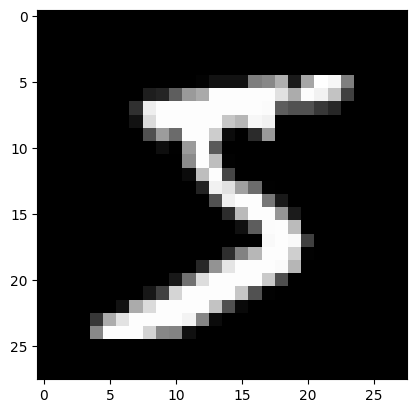

In [5]:
# サンプルのデータでmax poolingを実施
X_ = X[0, :, :]
max_out = max_pooling(X_)
print(max_out.shape)
plt.imshow(X_, cmap='gray')

In [6]:
# conv --> ReLU --> max_pooling
top_edge_filter = torch.tensor([ [-1, -1, -1],
                                  [0, 0, 0],
                                  [1, 1, 1]])

def apply_filter(image, filter):
    image_h, image_w = image.shape
    filter_h, filter_w = filter.shape
    output_data = []
    for i in range(image_h - filter_h + 1):
        row = []
        for j in range(image_w - filter_w + 1):
            row.append((image[i:i+filter_h, j:j+filter_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

def ReLU(X):
    return torch.clamp(X, min=0)

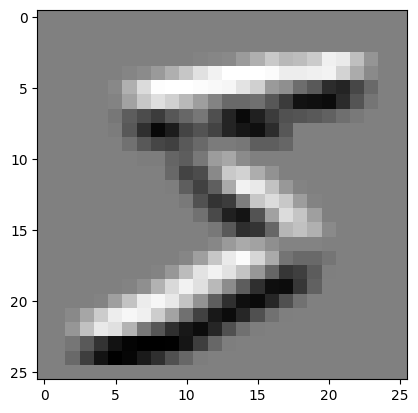

In [7]:
# 畳み込みの出力
conv_out = apply_filter(X_, top_edge_filter)
plt.imshow(conv_out, cmap='gray')

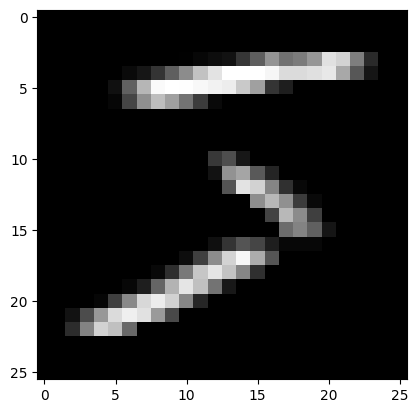

In [9]:
# ReLUの出力
relu_out = ReLU(conv_out)
plt.imshow(relu_out, cmap='gray')

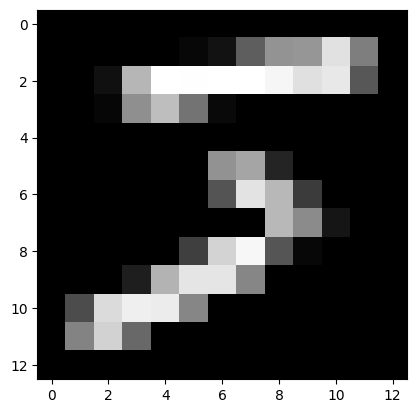

In [10]:
# Poolingの出力
max_out = max_pooling(relu_out)
plt.imshow(max_out, cmap='gray')

### pytorchのmax pooling layer

In [13]:
class ConvModel(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, output_channel, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        X = F.relu(self.conv5(X))
        out_put = self.flatten(X)
        return out_put

In [14]:
# サンプルデータで順伝播
X, y = next(iter(train_loader))
print(X.shape)
model = ConvModel(1, 10)
output = model(X)
output.shape

torch.Size([128, 1, 28, 28])


torch.Size([128, 10])

### Global Average Pooling Layerのスクラッチ実装

In [18]:
class GlobalAveragePooling2D(nn.Module):
    def forward(self, X):
        return torch.mean(X, dim=(2, 3), keepdim=True)

In [19]:
# サンプルのTensorで順伝播
X = torch.randn((128, 3, 4, 4))
gap_layer = GlobalAveragePooling2D()
output = gap_layer(X)
print(X.shape)
output.shape

torch.Size([128, 3, 4, 4])


torch.Size([128, 3, 1, 1])

### PytorchのGAP層

In [20]:
# nn.AdaptiveAvgPool2d(1)でGAPを実現する
gap_layer = nn.AdaptiveAvgPool2d(1)
output = gap_layer(X)
print(X.shape)
output.shape

torch.Size([128, 3, 4, 4])


torch.Size([128, 3, 1, 1])

### GAP層をCNNに追加

In [21]:
# GAPなしのモデル
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1

    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [22]:
# サンプルのTensorで順伝搬
X = torch.randn((128, 1, 28, 28))
out = conv_model(X)
out.shape

torch.Size([128, 10])

In [23]:
# 以下はエラーになる．
# 32x32など，最終的にサイズが28x28を入力にした時と同じように変化する場合はエラーにならない
X = torch.ones((16, 1, 64, 64))
out = conv_model(X)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x512 and 128x10)

In [25]:
# GAP層あり
conv_model_gap = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    nn.AdaptiveAvgPool2d(1),
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
)

In [26]:
# サンプルのTensorで順伝搬
# GAP層があるので入力サイズが可変
X = torch.randn((128, 1, 64, 64))
print(X.shape)
out = conv_model_gap(X)
out.shape

torch.Size([128, 1, 64, 64])


torch.Size([128, 10])